# POD-NN

This notebook trains a neural network to predict the projection of the high-fidelity solutions onto the reduced basis and evaluates the performance.

In [1]:
import torch
from torch import nn
import numpy as np
from tqdm import tqdm

import sys
sys.path.append("..")
from gfn_rom import pde, defaults, plotting, initialisation, preprocessing

In [2]:
pname="graetz"

reduced_coefficients = np.load("./data/projected_matrix.npy")
snapshots = np.load("./data/snapshot_matrix_large.npy")
basis_matrix = np.load("./data/basis_matrix.npy")

In [3]:
dev = initialisation.set_device()
initialisation.set_precision(defaults.precision)
params = torch.tensor(pde.params(pname)).to(dev)
np.random.seed(defaults.split_seed)
train_trajs, test_trajs = preprocessing.train_test_split(params, 1, defaults.rate)
train_trajs = train_trajs[0]
initialisation.set_seed(defaults.seed)

In [4]:
layers = [nn.Linear(params.shape[1], defaults.mapper_sizes[0]), defaults.act()]

for i in range(len(defaults.mapper_sizes)-1):
    layers.append(nn.Linear(defaults.mapper_sizes[i], defaults.mapper_sizes[i+1]))
    layers.append(defaults.act())
    
layers.append(nn.Linear(defaults.mapper_sizes[-1], reduced_coefficients.shape[1]))

model = nn.Sequential(*layers).to(dev)

In [5]:
model(params)

tensor([[-0.2353,  0.0100,  0.1141],
        [-0.2352,  0.0100,  0.1143],
        [-0.2352,  0.0099,  0.1146],
        [-0.2351,  0.0099,  0.1148],
        [-0.2350,  0.0099,  0.1150],
        [-0.2350,  0.0099,  0.1153],
        [-0.2349,  0.0099,  0.1155],
        [-0.2348,  0.0099,  0.1158],
        [-0.2348,  0.0098,  0.1160],
        [-0.2347,  0.0098,  0.1163],
        [-0.2346,  0.0098,  0.1165],
        [-0.2346,  0.0098,  0.1167],
        [-0.2345,  0.0098,  0.1170],
        [-0.2344,  0.0098,  0.1172],
        [-0.2344,  0.0097,  0.1175],
        [-0.2343,  0.0097,  0.1177],
        [-0.2342,  0.0097,  0.1180],
        [-0.2342,  0.0097,  0.1182],
        [-0.2341,  0.0097,  0.1184],
        [-0.2340,  0.0097,  0.1187],
        [-0.2374,  0.0025,  0.1172],
        [-0.2374,  0.0025,  0.1174],
        [-0.2373,  0.0025,  0.1176],
        [-0.2373,  0.0025,  0.1179],
        [-0.2372,  0.0025,  0.1181],
        [-0.2372,  0.0025,  0.1183],
        [-0.2371,  0.0024,  0.1186],
 

In [6]:
opt = torch.optim.Adam(model.parameters(), lr=defaults.lr, weight_decay=defaults.lambda_)

100%|████████████████████████| 5000/5000 [00:52<00:00, 94.77it/s, Loss(training)=0.000128, Loss(testing)=tensor(0.0007)]


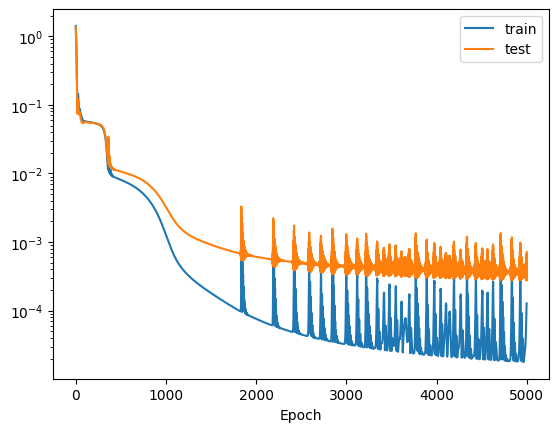

In [7]:
save_name = 'POD_NN'

true_reduced_coefficients = torch.tensor(reduced_coefficients).to(dev)

best_loss = np.inf

loss_func = nn.MSELoss()

train_losses = []
test_losses = []

params_train = params[train_trajs]
true_train = true_reduced_coefficients[train_trajs]
params_test = params[test_trajs]
true_test = true_reduced_coefficients[test_trajs]

loop = tqdm(range(defaults.epochs))
for i in loop:
    opt.zero_grad()
    
    preds_train = model(params_train)
    loss = loss_func(preds_train, true_train)
    loss.backward()
    opt.step()
    train_loss = loss.item()
    train_losses.append(train_loss)
    
    with torch.no_grad():
        preds_test = model(params_test)
        test_loss = loss_func(preds_test, true_test)
        test_losses.append(test_loss)
    loop.set_postfix({"Loss(training)": train_loss, "Loss(testing)": test_loss})
            
    if test_loss<best_loss:
        best_loss = test_loss
        best_epoch = i
        torch.save(model.state_dict(), "models/best_model_"+save_name+".pt")
    
model.load_state_dict(torch.load("models/best_model_"+save_name+".pt"))
plotting.plot_losses(train_losses, test_losses, save_name)

In [8]:
params = params.to('cpu')
model = model.to('cpu')
model.eval()

with torch.no_grad():
    predicted_coefficients = model(params)

predicted_snapshots = np.zeros(snapshots.shape)

for i in range(params.shape[0]):
    predicted_snapshots[i] = basis_matrix @ predicted_coefficients.numpy()[i]

In [9]:
def print_results(Z, Z_approx):
    Z = Z.T
    Z_approx = Z_approx.T
    
    error_abs_list = list()
    norm_z_list = list()

    for snap in range(Z.shape[1]):
        error_abs = np.linalg.norm(abs(Z[:, snap] - Z_approx[:, snap]))
        norm_z = np.linalg.norm(Z[:, snap], 2)
        error_abs_list.append(error_abs)
        norm_z_list.append(norm_z)

    error = np.array(error_abs_list)
    norm = np.array(norm_z_list)
    rel_error = error/norm
    print("\nMaximum absolute error for field "+" = ", max(error))
    print("Mean absolute error for field "+" = ", sum(error)/len(error))
    print("Minimum absolute error for field "+" = ", min(error))
    print("\nMaximum relative error for field "+" = ", max(rel_error))
    print("Mean relative error for field "+" = ", sum(rel_error)/len(rel_error))
    print("Minimum relative error for field "+" = ", min(rel_error))

In [10]:
print_results(predicted_snapshots, snapshots)


Maximum absolute error for field  =  3.871013697487897
Mean absolute error for field  =  1.6652271663892884
Minimum absolute error for field  =  0.20652734323577543

Maximum relative error for field  =  0.0849057557587199
Mean relative error for field  =  0.03537202353270947
Minimum relative error for field  =  0.0039295372041191915
